In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import random
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120

# Algorithm for generating money

$n_0$ people draw money from a money pool containing $M_0$ dollars:

Let $X_n$ be the remaining money in the pool after the $n$-th draw
($X \in [0, M_0]$, $0$-th draw means no draw has occurred), and uniform
random variable $K \sim \mathcal{U}(0, 1)$.

Let's define the algorithm to generate the money of the $i$-th draw:

$ M_i = $\begin{cases}
\max(0.01, K \frac{X_i}{n_c(i)}) & i=1,2,3,\dots n_0 - 1 \\
X_i & i = n_0 \\
\end{cases}

where $n_c(i)$ is the current number of players who haven't drawn, so
$n_c(i) = n_0 - i + 1$.

So $ M_i = $\begin{cases}
\max(0.01, K \frac{X_i}{n_0 - i + 1}) & i=1,2,3,\dots n_0 - 1 \\
X_i & i = n_0 \\
\end{cases}

In [3]:
class RedBag:
    def __init__(self, n_bags: int, money: float):
        self.n_remain = self.n_bags = n_bags
        self.money_remain = self.money = money

    def get_money(self):
        """
        Get money from this red bag
        :return: how much money of a new red bag
        """
        assert self.money_remain >= 0
        if self.n_remain ==  1:
            money = self.money_remain
            self.money_remain = 0
            self.n_remain = 0
        else:
            min_ = 0.01
            max_ = 2 * self.money_remain / self.n_remain
            money = np.random.uniform(0, 1.0, 1)[0] * max_
            money = max(min_, money)
            self.n_remain -= 1
            self.money_remain -= money
        return money

In [4]:
def sim_trial(n_bags: int, money: float):
    rb = RedBag(n_bags, money)
    trials = [rb.get_money() for _ in range(n_bags)]
    return trials

In [5]:
n_trials = 500
n_players = 10
money = 66.0
np.random.seed(1024)
data = np.asarray([sim_trial(n_players, money) for i in range(n_trials)]).T
data.shape

(10, 500)

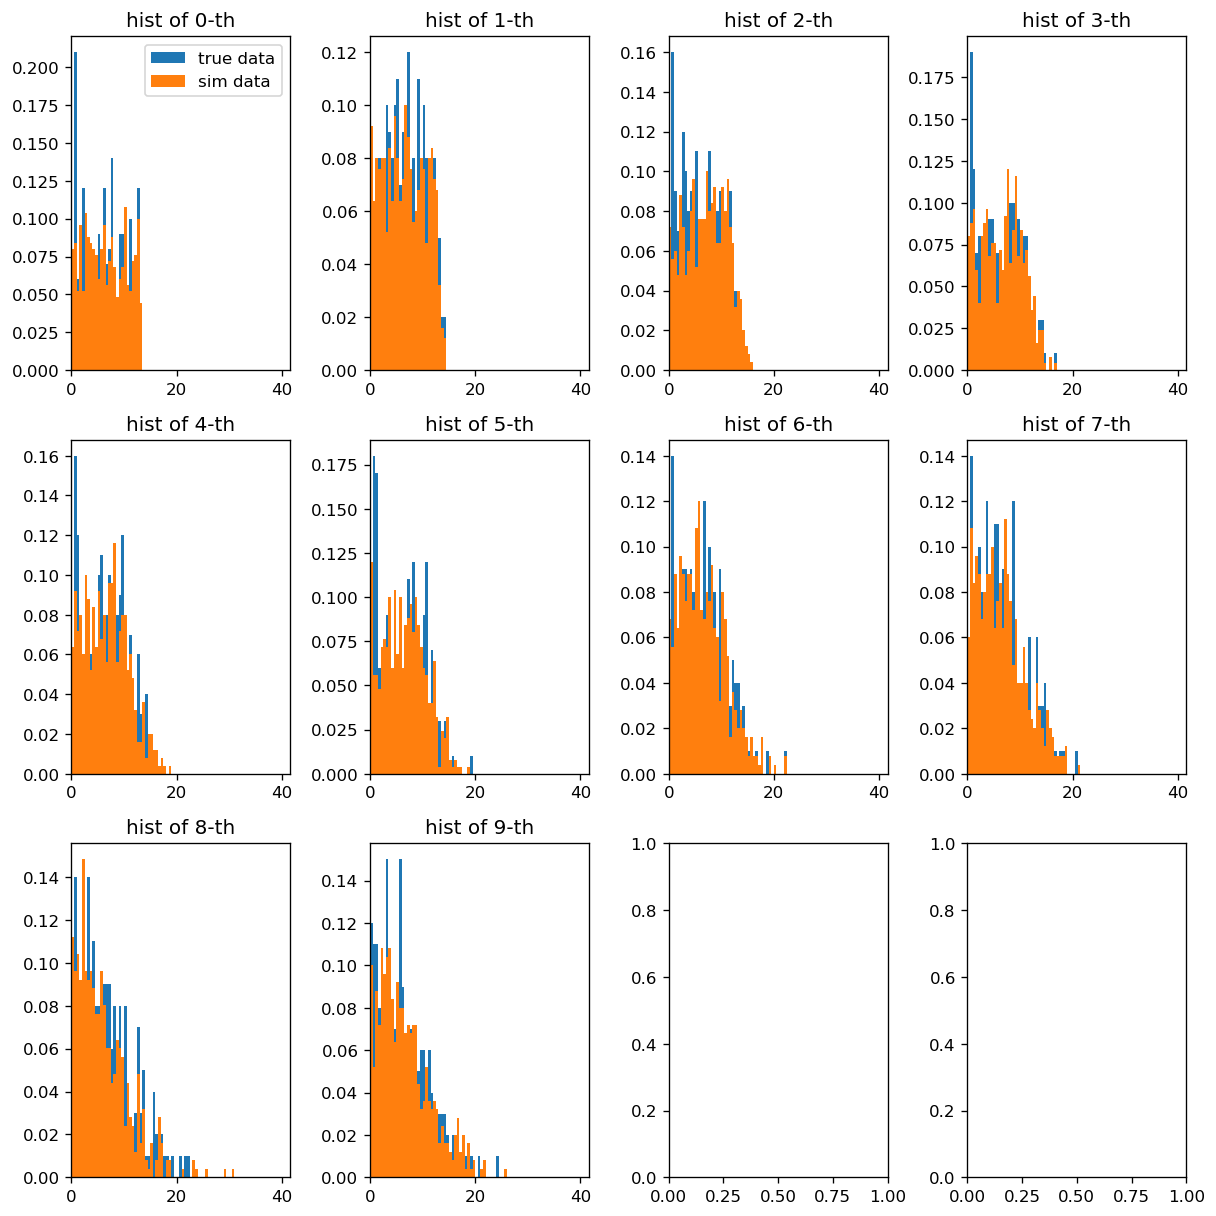

In [6]:
def plot_hist_for_players(data1: np.ndarray, data2: np.ndarray,
                          bin_size: float = 0.5):
    fig, axs = plt.subplots(3, 4)
    fig.set_size_inches(10.24, 10.24)
    axs = axs.flat
    xlim = max(np.max(data1), np.max(data2))
    bins = np.arange(0.0, xlim + 0.1, step=bin_size)
    for i in range(10):
        axs[i].hist(data1[i,], bins=bins, density=True, label="true data")
        axs[i].hist(data2[i,], bins=bins, density=True, label="sim data")
        axs[i].set_title('hist of {}-th'.format(i))
        axs[i].set_xlim([0, xlim])
    axs[0].legend()
    fig.tight_layout()
    plt.show()

data_true = np.loadtxt('trials.csv')
plot_hist_for_players(data_true, data)

In [7]:
def get_dist(data: np.ndarray, bin_size: float = 0.5):
    xlim = np.max(data)
    bins = np.arange(0.0, xlim + 0.1, step=bin_size)
    histogram = [np.histogram(data[i,], bins) for i in range(10)]
    hist = np.asarray([h[0] for h in histogram])
    dist = hist / data.shape[1]
    return dist, bins

$H_0$: Our algorithm of generating money create the same distribution as
the one that the experiment data is sampled from.

So we reject $H_0$ if $p < 1\% $, where $p$
is obtained by calculating Kolmogorov-Smirnov statistic on 2 samples data.

In [8]:
sim_dists, sim_bins = get_dist(data)
ks_stats = [stats.ks_2samp(data_true[i, ][data_true[i, ] != 0],
                           data[i, ][data[i, ] != 0])
            for i in range(data_true.shape[0])]
ks_stats = np.asarray(ks_stats)

md_str = """
|order| p |reject?|
|-----|---|-------|
|0    |{0:02}%|  {10}|
|1    |{1:02}%|  {11}|
|2    |{2:02}%|  {12}|
|3    |{3:02}%|  {13}|
|4    |{4:02}%|  {14}|
|5    |{5:02}%|  {15}|
|6    |{6:02}%|  {16}|
|7    |{7:02}%|  {17}|
|8    |{8:02}%|  {18}|
|9    |{9:02}%|  {19}|
"""

ps = (ks_stats[:, 1] * 100).astype(int)
md_str = md_str.format(*ps, *(ps < 1))
# Markdown(md_str)
print(md_str)



|order| p |reject?|
|-----|---|-------|
|0    |78%|  False|
|1    |08%|  False|
|2    |19%|  False|
|3    |83%|  False|
|4    |86%|  False|
|5    |38%|  False|
|6    |68%|  False|
|7    |97%|  False|
|8    |00%|  True|
|9    |38%|  False|



# Luckiest & Unluckiest Players

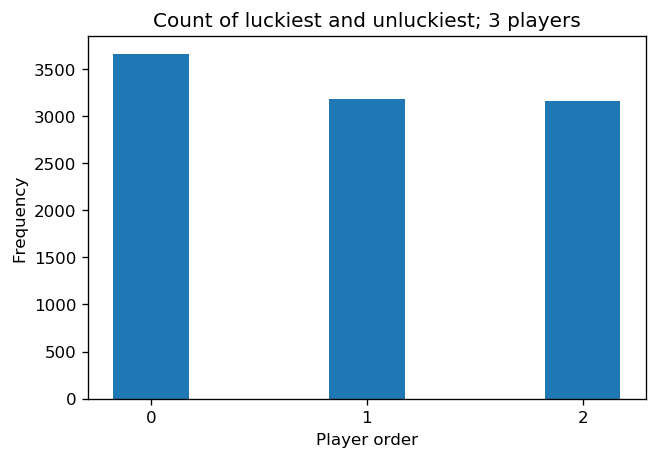

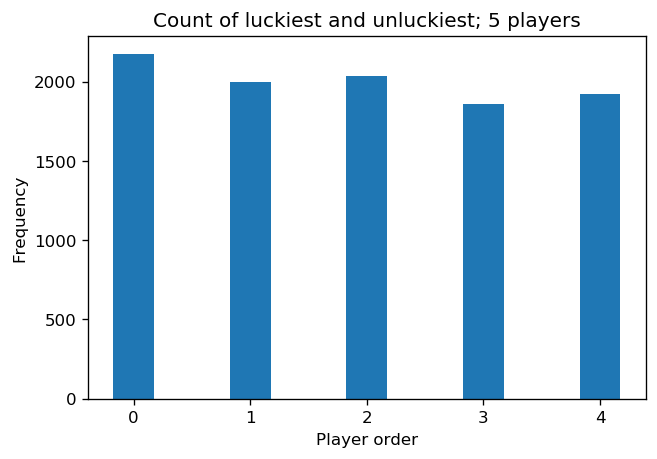

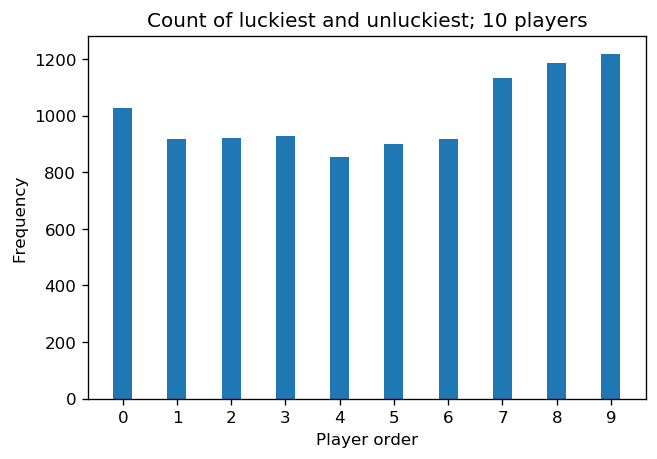

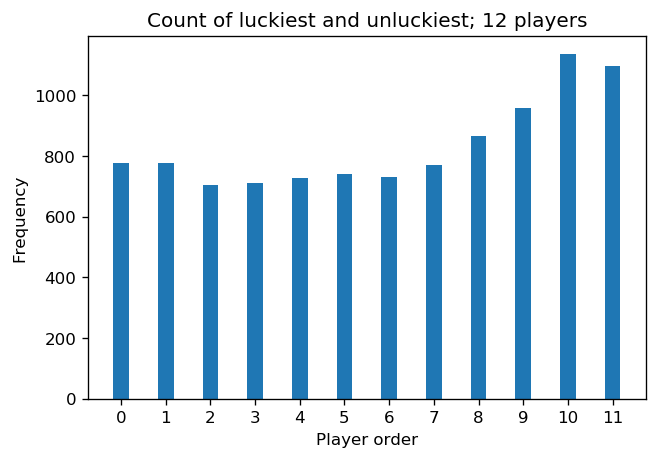

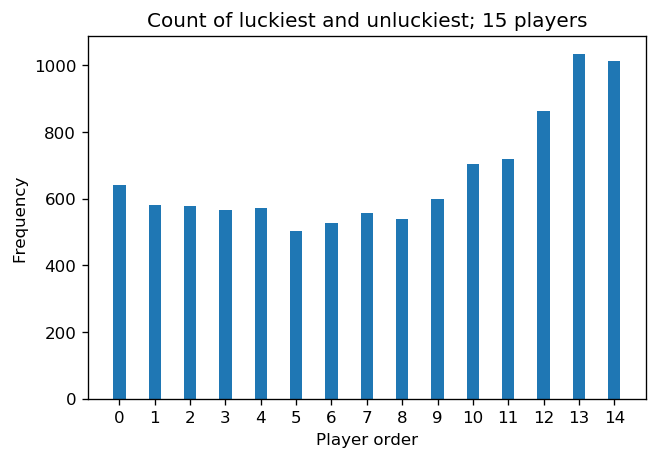

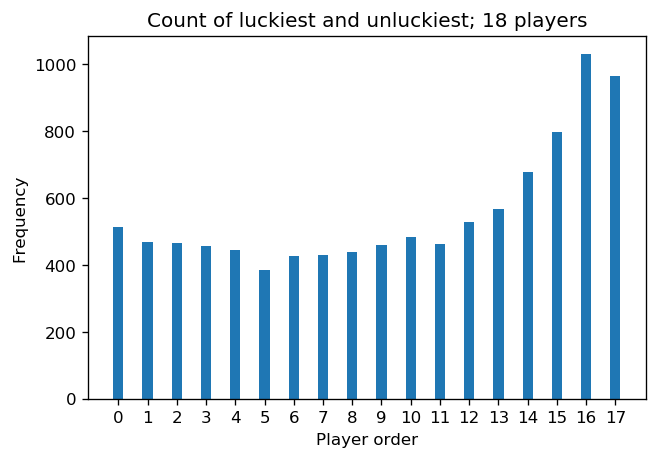

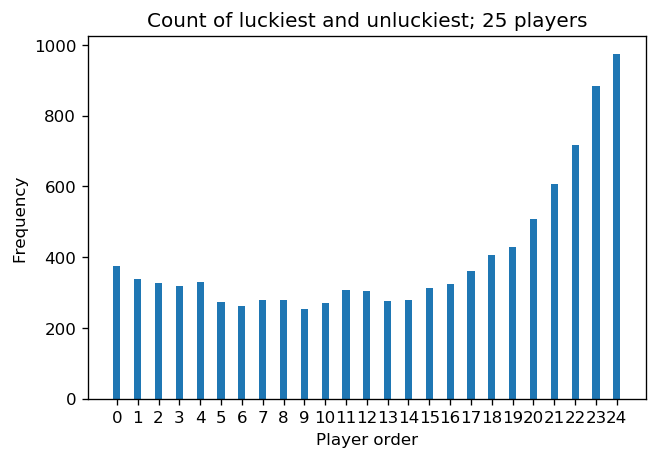

In [14]:
def plot_lucky_n_unlucky_players(data: np.ndarray, bar_width: float = 0.35):
    n_p = data.shape[0]
    lucky = np.unique(np.argmax(data, axis=0), return_counts=True)[1]
    # unlucky = np.unique(np.argmin(data, axis=0), return_counts=True)[1]
    labels = [str(i) for i in range(n_p)]
    fig, ax = plt.subplots()
    ax.bar(labels, lucky, width=bar_width, label='Lucky')
    # ax.bar(labels, unlucky, width=bar_width, bottom=lucky, label='Unlucky')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Player order')
    ax.set_title('Count of luckiest and unluckiest; {} players'.format(n_p))
    # ax.legend()
    plt.savefig('{}-players.png'.format(n_p))
    plt.show()

n_trials = 10000
# n_players = 4
money = 66.0
for n_players in [3, 5, 10, 12, 15, 18, 25]:
    np.random.seed(1024)
    data = np.asarray([sim_trial(n_players, money) for i in range(n_trials)]).T
    plot_lucky_n_unlucky_players(data)